# **Projet de recherche opérationnelle** - Vinh Nguyen & Victor Klötzer
### **Implémentation d'un Branch and Bound**
 *10 janvier 2021*

---

1. Génération d'instances du problème considéré  
2. Une modélisation en PLNE et résolution du problème avec le solveur CBC
3. Implémentation de l'algorithme de Branch and Bound  
   a. Création de la classe `Noeud` et des méthodes `borne_duale()` et `branching_rule()`  
   b. Fonctions `borne_primale()` et `exploration()`  
   c. Fonction `branch_and_bound()`
4. Étude de complexité des différents algorithmes

$\phantom{saut de ligne}$

Dans ce projet, on s'intéresse à la résolution d'un problème d'ordonnancement à l'aide d'un Branch and Bound générique. On souhaite d'abord implémenter ce dernier de différentes manières. Ensuite, on veut comparer leurs temps d'exécution et leurs complexités entre eux ainsi qu'avec une résolution par PLNE par le solveur CBC de Pulp.

*(Dans la partie 4. de ce projet, il y a un code qui a pris un peu plus de **6 minutes** sur nos machines. Pour gagner du temps, vous pouvez lancer tous les codes dès maintenant)*

### Tout d'abord, importation de modules Python

In [ ]:
# Installation de pulp
!pip install pulp

# Importation de modules python
from pulp import *
import numpy as np
import matplotlib.pyplot as plt
import time

     |████████████████████████████████| 40.6MB 111kB/s 


# **1. Génération d'instances du problème considéré**

Dans ce projet, on s'interessera au problème d'ordonnancement suivant :   
Un atelier de production doit usiner un ensemble $J = \{1 . . . , n\}$ de pièces. Pour cela, il dispose d’une machine unique et chaque pièce $j\in J$ nécessitera $p_j$ unités de temps pour être usinée. On suppose que l’on se trouve à la date $t = 0$ et chaque pièce $j\in J$ doit être prête à la date $d_j$. Si cette date n’est pas respectée, l’usine devra payer une pénalité $w_j$ par unité de temps de retard. Le problème consiste à déterminer l’ordre de passage des pièces sur la machine afin de minimiser les pénalités de retard.

$\phantom{saut de ligne}$

On doit tout d'abord générer des instances de ce problème. Afin de pouvoir valider les algorithmes que l'on codera par la suite, on veut dans un premier pouvoir récréer une instance simple dont on connait déjà la réponse (car elle peut se calculer à la main). Puis dans un second temps, on aura besoin d'instances aléatoires de ce problème pour pouvoir comparer les complexités des méthodes implémentées.  

On crée ainsi la classe `ProblemeOrdonnancement` qui permet soit de créer une instance à partir d'une liste de pièces à laquelle on associe les trois listes de temps d'usinage, de dates de fin d'usinage et de pénalités pour toutes les pièces à usiner. Ou bien, cette classe permet de générer une instance aléatoire de problème à partir d'un nombre de pièces et de valeurs maximales pour les temps, les dates de fin d'usinage ainsi que les pénalités.  

Cependant, afin que l'on puisse générer des instances aléatoires de tailles différentes (nombre de pièces), on peut se poser des questions quand au choix d'une date maximale de fin d'usinage ainsi que de la valeur maximale d'une pénalité. En effet, on souhaite que quelque soit la taille du problème étudié, celui-ci soit pareillement "compliqué" à résoudre.  
*  Il semble donc cohérent d'imposer que les dates de fin d'usinage des pièces soient strictement inférieures à la somme de tous les temps d'usinage. Cela permet d'imposer le fait qu'il y aura des pénalités ($>0$). On propose ainsi ici que la date maximale de fin d'usinage soit égale à 50% de la somme de tous les temps d'usinage des pièces. Cela permet d'ailleurs aussi, de contrôler pareillement la variance des dates de fin d'usinage en fonction du nombre de pièces.   
*  De la même manière, on souhaite contrôler la variance des pénalités en fonction du nombre de pièce afin qu'une pièce avec une grande (ou petite) pénalité ne soit pas trop dominante (ou trop peu influente) par rapport aux autres pièces. On décide donc ici d'avoir une pénalité maximale égale aux nombres de pièces.

In [ ]:
class ProblemeOrdonnancement:
  """ Génération aléatoire d'une instance ou création d'une instance à partir de quatre listes :
      les pièces, les temps d'usinage, les dates d'usinage et les pénalités """
  def __init__(self, pieces = [], temps_usinage = [], dates_usinage = [], penalites = []):
    self.J = list(pieces)                     # liste des pièces
    self.T = dict(zip(self.J, temps_usinage)) # dictionnaire avec les temps d'usinage associés à chacune des pièces
    self.D = dict(zip(self.J, dates_usinage)) # dictionnaire avec les dates de fin d'usinage associées à chacune des pièces
    self.W = dict(zip(self.J, penalites))     # dictionnaire avec les pénalités d'usinage associées à chacune des pièces

  def generer_instance_probleme(self, set_seed, nb_pieces, temps_max, date_max = None, penalite_max = None):
    np.random.seed(set_seed)
    self.J = [i for i in range(1, nb_pieces + 1)]
    self.T = dict(zip(self.J, np.random.choice(range(1, temps_max + 1), nb_pieces))) # temps d'usinage entre 1 et temps_max
    
    somme_tps = int(0.5 * sum(self.T.values()))
    if (date_max == None):
      self.D = dict(zip(self.J, np.random.choice(range(1, somme_tps + 1), nb_pieces))) # dates de fin d'usinage entre 1 et somme_tps
    else: 
      self.D = dict(zip(self.J, np.random.choice(range(1, date_max + 1), nb_pieces))) # dates de fin d'usinage entre 1 et date_max
    
    if (penalite_max == None):
      self.W = dict(zip(self.J, np.random.choice(range(1, nb_pieces + 1), nb_pieces))) # pénalités entre 1 et nb_pieces
    else :
      self.W = dict(zip(self.J, np.random.choice(range(1, penalite_max + 1), nb_pieces))) # pénalités entre 1 et penalite_max


In [ ]:
# Test de la fonction

exemple = ProblemeOrdonnancement()
exemple.generer_instance_probleme(0, 6, 15) # 6 pièces avec des temps d'usinage d'au plus 15 et set_seed=0

print("Pièces :          ", exemple.J)
print("Temps d'usinage : ", exemple.T)
print("Dates de fin :    ", exemple.D)
print("Poids :           ", exemple.W)

Pièces :           [1, 2, 3, 4, 5, 6]
Temps d'usinage :  {1: 13, 2: 6, 3: 1, 4: 4, 5: 12, 6: 4}
Dates de fin :     {1: 8, 2: 10, 3: 20, 4: 19, 5: 5, 6: 7}
Poids :            {1: 1, 2: 1, 3: 5, 4: 3, 5: 2, 6: 1}


# **2. Une modélisation en PLNE et résolution du problème avec le solveur CBC**

On modélise tout d'abord ce problème sous la forme d'un programme linéaire en nombre entiers. Pour cela on utilise les variables suivantes :   
$\forall j\in J : r_j =$ retard en unité de temps de la pièce $j$   
$\forall j\in J : f_j =$ date de fin d'usinage de la pièce $j$     
$\forall (i,j) \in J^2 : x_{ij} =
\left\{
\begin{aligned}
	& 1~ \text{ si } i \text{ passe de devant } j \text{ sur la machine}\\
	& 0~ \text{ sinon }
\end{aligned}
\right.
$ .

$\phantom{saut de ligne}$

On écrit alors le problème de minimisation comme suit :  
$$
\left\{
\begin{aligned}
	\min\quad & \sum\limits_{j\in J} \omega_j r_j \\
	\text{sous}\quad & r_j \ge 0 &\forall j \in J ~~~~~~(1)\\
	\quad & r_j \ge f_j - d_j &\forall j \in J  ~~~~~~(2)\\
	\quad & f_j = p_j + \sum\limits_{i\in J\backslash\{i\}}x_{ij} p_i  &\forall j \in J ~~~~~~(3)\\
	\quad & x_{ij} + x_{ji} = 1 &\forall (i,j) \in J^2, ~i<j ~~~~~~(4)\\
	\quad & x_{ik} \ge x_{ij} + x_{jk} - 1 &\forall (i,j,k) \in J^3,~ i \ne j,~ j\ne k,~ i\ne k ~~~~~~(5)\\
\end{aligned}
\right.
$$

$\phantom{saut de ligne}$

**Explication des contraintes :**  
Ce problème étant une minimisation (et $\omega_j >0, \forall j\in J$), les containtes $(1)$ et $(2)$ assurent que quelque soit la pièce $j$, son retard d'usinage $r_j$ sera égal à $0$ s'il n'y a pas de retard ou alors sera égal à $f_j - d_j$, à savoir la différence entre le date de fin d'usinage et la date limite souhaitée.   
La contrainte $(3)$ fixe la valeur de la date de fin d'usinage $f_j$ pour toutes les pièces $j$, connaissant l'ordre de passage des pièces sur la machine.   
Les contraintes $(4)$ et $(5)$ permettent d'imposer une relation d'ordre total strict sur l'usinage des pièces. La contrainte $(4)$ vérifie en effet qu'il y ait un ordre total sur l'usinage des pièces, et la contrainte $(5)$ permet d'assurer la transitivité de cette relation.

$\phantom{saut de ligne}$

On implémente par la suite cette PLNE dans la fonction `PLNE` qui prend en paramètre une instance du problème de type `ProblemeOrdonnancement` :

In [ ]:
def PLNE(instance_probleme, affichage = True):
  """ Fonction qui résout par PLNE le problème d'ordonnancement de ce projet et retourne l'ordre d'usinage des pièces
      - instance_probleme : une instance d'un problème d'ordonnancement de type 'ProblemeOrdonnancement'
      - affichage : True ou False pour afficher ou non la modélisation PLNE """

  J = instance_probleme.J   # liste des pièces
  T = instance_probleme.T   # dictionnaire avec les temps d'usinage associés à chacune des pièces
  D = instance_probleme.D   # dictionnaire avec les dates de fin d'usinage associées à chacune des pièces
  W = instance_probleme.W   # dictionnaire avec les pénalités d'usinage associées à chacune des pièces
  
  prob = LpProblem("PLNE", LpMinimize) # Problème de minimisation

  ## VARIABLES
  r = LpVariable.dicts("r", J, lowBound = 0, cat=LpInteger) # retards d'usinage en unité de temps         => Contrainte (1)
  f = LpVariable.dicts("f", J, lowBound = 0, cat=LpInteger) # dates de fin d'usinage
  x = LpVariable.dicts("x", (J,J), 0, 1, LpInteger) # x_ij = 1 si i est usiné avant j, 0 sinon

  ## OBJECTIF
  prob += lpSum( W[j] * r[j] for j in J ) 

  ## CONTRAINTES
  for j in J:
    prob += r[j] >= f[j] - D[j], "Contrainte (2) pour "+str(j)

  for j in J:
    prob += f[j] == T[j] + lpSum(T[i]*x[i][j] for i in J if i != j), "Contrainte (3) pour "+str(j)
    
  for j in J:
    for i in range(1,j):
      prob += x[i][j] + x[j][i] == 1, "Contrainte (4) pour "+str(i)+","+str(j)

  for k in J:
    for j in J:
      for i in J:
        if (i!=j) and (j!=k) and (k!=i):
          prob += x[i][k] >= x[i][j] + x[j][k] - 1, "Contrainte (5) pour "+str(i)+","+str(j)+","+str(k)
  
  # On obtient le problème suivant :
  #prob.writeLP("PLNE.lp")
  if affichage:
    print(prob)

  # Résolution du problème par CBC
  prob.solve(PULP_CBC_CMD())

  if affichage:
    # On vérifie que le problème est solvable :
    print("Solve with CBC")
    print("Status:", LpStatus[prob.status])
    # Affichage de la pénalité de retard totale trouvée :
    print("\nPénalité de retard totale =", value(prob.objective),"\n")
    # Valeur des variables x_ij (i<j):
    for j in J:
      for i in range(1,j):
        print("x_",i,",",j," = ",x[i][j].varValue, sep="")
    print("")

  # On retourne finalement l'ordre d'usinage retenu
  ordre_usinage = [None]*len(J)
  for i in J:
    nb_pieces_avant = int( np.sum([x[j][i].varValue for j in J if j>i]) + np.sum([1 - x[i][j].varValue for j in J if j<i]) ) # Nombre de pièces usinée avant la pièce i
    ordre_usinage[nb_pieces_avant] = i
  
  if affichage:
    print("L'ordre d'usinage des pièces est le suivant :\n", ordre_usinage)
  
  return ordre_usinage


In [ ]:
# Test avec l'exemple du TD. On doit retrouver l'ordre 1,2,4,3
J = [ 1,  2,  3,  4]
T = [12,  8, 15,  9]
D = [16, 26, 25, 27]
W = [ 4,  5,  3,  5]
instance_exemple = ProblemeOrdonnancement(J, T, D, W)

ordre = PLNE(instance_exemple, affichage=False)
print(ordre)

[1, 2, 4, 3]


# **3. Implémentation de l'algorithme de Branch and Bound**

Dans cette partie, on va implémenter un algorithme générique du Branch and Bound pour le problème d'ordonnancement étudié. On va entre autre écrire et tester différentes méthodes pour chaque composante du Branch and Bound, à savoir pour le calcul des bornes, pour la règle de branchement et pour la méthode d'exploration.


## 3.a. Création de la classe `Noeud` et des méthodes `borne_duale()` et `branching_rule()`

Pour commencer, on définit une classe `Noeud`. Celle-ci permettra de créer des nœuds de branchement contenant l'ordre d'usinage de pièces déjà connu à ce nœud, la valeur de la borne duale et de savoir si le nœud a été élagé ou non. Un nœud est ici créé à partir de son nœud père et de l'ordre des pièces que l'on l'on connait au niveau de ce nœud. 

La classe `Noeud` contient également des attributs de classe qui sont une instance du problème d'ordonnancement `instance_probleme` ainsi que deux variables `fct_borne_duale` et `fct_branching` qui permettent de choisir le calcul de borne duale utilisé ainsi que la règle de branchement utilisé.  
(Ces attributs de classe servent à paramétrer le Branch and Bound et permettront une implémentation simple dans la fonction `branch_and_bound()` que nous définirons plus tard.)

Ces attributs permettent enfin de définir toujours dans la même classe `Noeud`, des méthodes de calcul de borne duale et de règle de branchement sur un nœud (sur un objet de type `Noeud`). On calculera ainsi la borne duale d'un nœud dès qu'il sera créé (voir le code ci-dessous).


$\phantom{saut de ligne}$

On implémente ici deux différents calculs de borne duale et deux règles de branchement différentes. Ces deux versions correspondent en fait à deux différentes manières de brancher le problème : soit on ajoute les pièces qui seront usinées dans l'ordre chronologique (version 1), soit dans l'ordre antichronologique (version 2).  

Pour les calculs de borne duale on additionne les pénalités des pièces dont l'ordre est déjà fixé. Dans le cas chronologique, on peut même ajouter en plus des pénalités pour les pièces qui ne sont pas encore ordonnées. En effet, si k pièces sont déjà ordonnées, on peut alors considérer que les autres pièces seront toutes usinées en position (k+1) et ajouter les pénalités associées.

Il ne sera bien entendu pas possible d'utilisé la version 1 de calcul de borne duale avec la version 2 de branchement, ou inversement. On obtient ainsi les deux versions des méthodes implémentées ci-dessous dans la classe `Noeud`.

In [ ]:
class Noeud:
  """ Classe Noeud """

  ## Attributs de classe :
  instance_probleme = None # Objet de type ProblemeOrdonnancement
  fct_borne_duale_et_branching = None # Prend en valeur "version1" ou "version2" :
                                      # version de calcul de borne duale et de règle de branchement qui sera utilisée
  

  def __init__(self, pere = None, ordre = []):
    """ Constructeur d'un noeud """
    self.ordre = ordre # Ordre d'usinage des pièces connu dans ce noeud
    self.borne_duale = self.__borne_duale() # On calcule la borne duale ès la création du noeud (cf. fonction ci-dessous)
    self.pruned = False # Noeud élagé : vrai ou faux


  def __borne_duale(self): 
    """ Calcul de la borne duale de ce noeud. Deux versions ont été codées :
         -  'version_1' : calcul de la borne duale lorsque l'on fixe l'ordre des premières pièces qui seront usinées
         -  'version_2' : calcul de la borne duale lorsque l'on fixe l'ordre des dernières pièces qui seront usinées 
        Cette méthode renvoie une borne duale du noeud """

    ##############################################################################################################################################
    ##  Version 1 : On calcule les pénalités des k pièces dont l'ordre est déjà fixé (ici ce sont les PREMIÈRES pièces usinées qui sont connues)
    ##              et on y ajoute les pénalités des autres pièces comme s'il elles étaient en positions (k+1)
    if Noeud.fct_borne_duale_et_branching == 'version_1':

      T = Noeud.instance_probleme.T
      D = Noeud.instance_probleme.D
      W = Noeud.instance_probleme.W

      z_d = 0
      f = 0 # Date de fin d'usinage de la pièce
      for j in self.ordre: # On parcours les pièces déjà ordonnées
        f += T[j]
        if f > D[j]:
          z_d += (f - D[j])*W[j] # On ajoute la pénalité de ces pièces
      
      non_ordonnees = set(Noeud.instance_probleme.J) - set(self.ordre) # Ensemble des pièces pas encore ordonnées dans ??? (restriction P)
      
      for i in non_ordonnees:
        fi = f + T[i] # la date de fin d'usinage des pièces non ordonnées 
        if fi > D[i]:
          z_d += (fi - D[i])*W[i] 

      return z_d

    ##############################################################################################################################################
    ##  Version 2 : On calcule les pénalités des k pièces dont l'ordre est déjà fixé (ici ce sont les DERNIÈRES pièces usinées qui sont connues)
    ##              et on y ajoute les pénalités des autres pièces comme s'il elles étaient toutes usinées juste avant ces k pièces
    elif Noeud.fct_borne_duale_et_branching == 'version_2': 
      
      T = Noeud.instance_probleme.T
      D = Noeud.instance_probleme.D
      W = Noeud.instance_probleme.W
      date_de_fin = np.sum(list(T.values())) # Somme des temps d'usinage de toutes les pièces

      z_d = 0 # La borne duale sera égale à la somme des pénalités de pièces déjà ordonnées par la fin
      for j in self.ordre[::-1]: # On parcours les pièces dans l'ordre inverse
        if date_de_fin > D[j]: # Si la date de fin d'usinage des pièces a dépassé la date de fin d_j souhaitée
          z_d += (date_de_fin - D[j])*W[j] # on ajoute la pénalité correspondante à z_d
        date_de_fin -= T[j] # màj de la date de fin en retirant le temps d'usinage de la pièce j regardée
      
      return z_d

    # Si le nom de version a été mal renseigné
    else:
      print("Erreur de nom de version dans 'Noeud.__borne_duale()'")


  def la_borne_duale_est_optimale(self): # C'est une version très simple : si tout l'ordre du noeud est déterminé alors la borne duale est optimale
    """ Regarde si oui ou non la borne duale calculée est optimale pour ce noeud """
    return len(self.ordre) == len(Noeud.instance_probleme.J)


  def branching_rule(self):
    """ Règle de branchement :
         -  'version1' : branchement dans l'ordre chronologique : l'ordre des premières pièces à usiner a été fixé et on cherche la pièce suivante
         -  'version2' : branchement dans l'ordre antichronologique : l'ordre des dernières pièces à usiner a été fixé et on cherche la pièce précédente 
        Cette méthode renvoie la liste des noeuds fils du noeud sur lequel on branche """

    #########################################################################################################################################
    ##  Version 1 : branchement dans l'ordre chronologique d'usinage des pièces (est utilisé avec la version 1 de calcul de borne duale)
    if Noeud.fct_borne_duale_et_branching == 'version_1': 

      noeuds_fils = [] # Liste qui contiendra les noeuds fils
      non_ordonnees = set(Noeud.instance_probleme.J) - set(self.ordre) # Ensemble des pièces pas encore ordonnées dans ce Noeud
      for j in non_ordonnees:
        noeuds_fils.append( Noeud(pere = self, ordre = self.ordre + [j]) )
      
      return noeuds_fils

    ##########################################################################################################################################
    ##  Version 2 : branchement dans l'ordre ANTIchronologique d'usinage des pièces (est utilisé avec la version 2 de calcul de borne duale)
    elif Noeud.fct_borne_duale_et_branching == 'version_2': 

      noeuds_fils = [] # Liste qui contiendra les noeuds fils
      non_ordonnees = set(Noeud.instance_probleme.J) - set(self.ordre) # Ensemble des pièces pas encore ordonnées dans ce Noeud
      for j in non_ordonnees:
        noeuds_fils.append( Noeud(pere = self, ordre = [j] + self.ordre) )
      
      return noeuds_fils
    
    # Si le nom de version a été mal renseigné
    else:
      print("Erreur de nom de version dans 'Noeud.branching_rule()'")


## 3.b. Fonctions `borne_primale()` et `exploration()`

Maintenant que l'on a créé une structure pour les noeuds et que l'on a implémenté deux versions de calcul de borne duale ainsi que deux règles de branchement, on s'intéresse au calcul de la borne primale que l'on utilisera au début du Branch and Bound.

On se propose d'implémenter deux différentes versions de calcul de borne primale que l'on nommera $\alpha$ et $\beta$ :
*  Version $\alpha$ : On calcule une solution réalisable du problème en usinant les pièces selon l'ordre chronologique des dates de fin d'usinage.
*  Version $\beta$ : En partant de la fin, on met à la dernière position disponible, la pièce non traitée donnant lieu à la plus petite pénalité de retard.

In [ ]:
def borne_primale(instance_probleme, version):
  """ Fonction de calcul de borne primale pour un problème d'ordonnancement. Elle prend en paramètres
       - instance_probleme : une instance d'un problème d'ordonnancement de type 'ProblemeOrdonnancement'
       - version : "version_alpha" ou "version_beta" en fonction du type de calcul de borne primale choisi 
      Cette fonction revoie une borne primale du problème ainsi l'ordre d'usinage des pièces associé """

  J = instance_probleme.J[:] # copie sans modification de la liste originale
  T = instance_probleme.T
  D = instance_probleme.D
  W = instance_probleme.W

  T_val = list(T.values())[:]
  D_val = list(D.values())[:]
  W_val = list(W.values())[:]

  ##############################################################################################################################################
  ##  Version alpha : on usine les pièces selon l'ordre chronologique des dates de fin d'usinage et on calcule les pénalités associées
  if version == "version_alpha":

    keydict = dict(zip(J, D_val))
    J.sort(key = keydict.get)
    ordre = J
    
    z_p = 0

    fi = 0
    for i in ordre:
      fi += T_val[i-1]
      if fi > D_val[i-1]:
        z_p += (fi - D_val[i-1])*W_val[i-1]

    return z_p, ordre

  ##########################################################################################################################################################
  ##  Version beta : en partant de la fin, on met à la dernière position disponible, la pièce non traitée donnant lieu à la plus petite pénalité de retard
  elif version == "version_beta":
    
    ordre = []
    maxi = len(J)
    z_p = 0
    date_de_fin = np.sum(T_val)

    while (len(ordre) < maxi):      
      liste = [date_de_fin - i if (date_de_fin - i > 0) else 0 for i in D_val]
      penalties =  [a*b for a,b in zip(liste, W_val)] # Calcul les pénalties de retard de chaque pièce en les mettant en dernière
      
      indice_min = penalties.index(min(penalties)) # On cherche l'indice  de l'élément donnant lieu à la plus petite pénalité de retard
      z_p += min(penalties)

      date_de_fin -= T_val[indice_min]
      T_val.remove(T_val[indice_min]) # Mettre à jour les éléments non traité
      
      ordre.insert(0,J[indice_min]) # Ajouter dans la liste d'ordre d'usinage

      # Mettre à jour les listes en enlevant les pieces traitées
      J.remove(J[indice_min])
      D_val.remove(D_val[indice_min])
      W_val.remove(W_val[indice_min])

    return z_p, ordre
  
  # Si le nom de version a été mal renseigné
  else:
    print("Erreur de nom de version dans 'borne_primale()'")


In [ ]:
# Test avec l'exemple du TD. On doit retrouver 136 et l'ordre 1,3,2,4 pour la version alpha, et 67 avec l'ordre 1,2,4,3 pour la version beta
J = [ 1,  2,  3,  4]
T = [12,  8, 15,  9]
D = [16, 26, 25, 27]
W = [ 4,  5,  3,  5]
instance_exemple = ProblemeOrdonnancement(J, T, D, W)

print("Valeur primale et ordre d'usinage asscocié :")
print("  - version alpha :", borne_primale(instance_exemple, "version_alpha"))
print("  - version beta : ", borne_primale(instance_exemple, "version_beta"))

Valeur primale et ordre d'usinage asscocié :
  - version alpha : (136, [1, 3, 2, 4])
  - version beta :  (67, [1, 2, 4, 3])


Il ne reste désormais plus qu'à choisir des méthodes d'exploration de l'arbre de branchement afin de pouvoir ensuite implémenter un algorithme générique du Branch and Bound.

On implémente trois méthodes d'exploration : en largeur, en profondeur et "le meilleur d'abord". Cette dernière méthode consiste à traiter le nœud ayant la plus petite borne duale parmi tous les nœuds non traité. Voici donc la fonction `exploration()` :

In [ ]:
def exploration(Q, noeuds, type_exploration):
  """ Fonction d'exploration de l'arbre de branchement. Elle prend en paramètres
       - Q : la liste des noeuds qui reste à traiter
       - noeuds : la liste des noeuds obtenus par le branchement et à ajouter à la liste Q
       - type_exploration : "largeur", "profondeur" ou "meilleur" en fonction du type d'exploration souhaité
      Cette fontion renvoie la liste des noeuds à traiter nouvellement ordonné (le premier noeud de la liste est celui qui doit être traité en premier) """
  
  if   type_exploration == 'largeur':
    return Q + noeuds

  elif type_exploration == 'profondeur':
    return noeuds + Q

  elif type_exploration == 'meilleur':
    return sorted(Q + noeuds, key = lambda x : x.borne_duale, reverse = False)
  
  # Si le nom de type d'exploration a été mal renseigné
  else:
    print("Erreur de nom de type d'exploration dans 'exploration()'")

## 3.c. Fonction `branch_and_bound()`


Grâce à la classe `Noeud` et aux quatre fonctions `borne_primale()`, `borne_duale()`, `branching_rule()`et `exploration()` codées ci-dessus, on peut donc finalement écrire une fonction **`branch_and_bound()`**.



In [ ]:
def branch_and_bound(instance_probleme, version_BD_et_branch = 'version_1', version_BP = 'version_alpha', type_exploration = 'meilleur'):
  """ La fonction Branch and Bound. Elle prend en paramètres :
       - instance_probleme : une instance d'un problème d'ordonnancement de type 'ProblemeOrdonnancement'
       - version_BD_et_branch : version de calcul de borne duale et de règle de branchement utilisés ("version_1" ou "version_2")
       - version_BP : version de calcul de borne primale utilisé ("version_alpha" ou "version_beta")
       - type_exploration : type de méthode d'exploration utilisé ("largeur", "profondeur" ou "meilleur")
      Cette fonction renvoie la valeur optimale du problème entré, l'ordre optimal d'usinage des pièces associés et le nombre de noeuds qui seront utilisés dans ce Branch and Bound """

  ## Il faut tout d'abord initialiser le problème dans la classe Noeud, à savoir spécifier l'instance du problème surlaquelle on veut travailler ici
  Noeud.instance_probleme = instance_probleme
  Noeud.fct_borne_duale_et_branching = version_BD_et_branch # On précise également les fonctions de calcul de borne duale et de règle de branchement qui seront utilisées

  z_p, ordre = borne_primale(Noeud.instance_probleme, version_BP) # On initialise 'z_p' et 'ordre' avec une première borne primale calculée pour ce problème
                                                                  # et avec l'ordre d'usinage de pièces associés
  
  nb_noeuds = 0 # Compteur du nombre de noeuds qui seront utilisés dans ce Branch and Bound
  Q = [ Noeud(pere=None, ordre=[]) ] # Contiendra la liste des problèmes/Noeuds encore à traiter
                                     # On y insère pour l'instant le problème initial : 
                                     #  - un Noeud qui n'a pas de père
                                     #  - et dont l'ordre d'usinage d'aucune pièce n'est connu

  while Q != []: # Tant qu'il reste un noeud à traiter
    P = Q[0] # Restriction P du problème initial à laquelle on s'intéresse dans cette boucle du while
    del Q[0] # On supprime ce Noeud P de la liste Q des problèmes/Noeuds à traiter
    nb_noeuds += 1

    z_d = P.borne_duale # On récupère la borne duale du Noeud P
    if z_d >= z_p:
      P.pruned = True # On élage ce noeud
    elif P.la_borne_duale_est_optimale(): # Si on arrive à montrer que z_d est valeur optimale de P
      z_p = z_d
      ordre = P.ordre # L'ordre d'usinage est mis à jour avec l'ordre de ce noeud
      P.pruned = True # On élage ce noeud
    else:
      Q = exploration(Q, P.branching_rule(), type_exploration) # Renvoie les noeuds qui doivent encore être traités
                                                               # (c'est toujours le premier noeud de la liste Q qui sera traité à la prochaine itération)
    
  return z_p, ordre, nb_noeuds

In [ ]:
# Test avec l'exemple du TD. On doit retrouver un valeur optimale de 67 avec l'ordre d'usinage optimal 1,2,4,3
J = [ 1,  2,  3,  4]
T = [12,  8, 15,  9]
D = [16, 26, 25, 27]
W = [ 4,  5,  3,  5]
instance_exemple = ProblemeOrdonnancement(J, T, D, W)

print("Algorithme de Branch and Bound avec différentes versions des fonctions qui le compose")
print("  - versions 2, alpha et meilleur :   ", branch_and_bound(instance_exemple, 'version_2', 'version_alpha', 'meilleur'))
print("  - versions 1, beta et largeur :     ", branch_and_bound(instance_exemple, 'version_1', 'version_beta', 'largeur'))  
print("  - versions 2, beta et profondeur :  ", branch_and_bound(instance_exemple, 'version_2', 'version_beta', 'profondeur'))  

Algorithme de Branch and Bound avec différentes versions des fonctions qui le compose
  - versions 2, alpha et meilleur :    (67, [1, 2, 4, 3], 11)
  - versions 1, beta et largeur :      (67, [1, 2, 4, 3], 23)
  - versions 2, beta et profondeur :   (67, [1, 2, 4, 3], 8)


# **4. Étude de complexité des différents algorithmes**

On veut pour terminer comparer les performances des différentes fonctions composant le Branch and Bound. On va donc, pour différentes paramétrisations de la fonction `branch_and_bound()`, tracer les temps d'exécution en fonction de la taille de problèmes d'ordonnancement aléatoires, i.e en fonction du nombre de pièces qui doivent être usinées. On va également tracer et comparer le nombre de nœuds de branchement nécessaire en fonction de la taille du problème.

Enfin, les temps d'exécutions seront également comparés à la PLNE codée plus tôt.   
(Nous aurions aussi voulu comparer le PLNE aux autres algorithmes avec le nombre de nœuds de branchement, mais nous n'avons pas trouvé comment accéder à cette information dans le solveur CBC de Pulp.)

Le Branch and Bound étant un algorithme de complexité NP, on s'attend à trouver des courbes exponentielles. On les passera donc en échelle logarithmique.


### Calculs des complexités des algorithmes
**(ATTENTION cette section s'exécute en un peu plus de 6 minutes sur nos machines)**

In [ ]:
def tempsExec_BandB(NB_pieces, version_BD_et_branch = 'version_1', version_BP = 'version_alpha', type_exploration = 'meilleur'):
  """ Temps d'exécution de la fonction 'branch_and_bound()' pour des instances aléatoires du problème d'ordonnancement 
       - NB_pieces : liste des tailles de problème d'ordonnancement (nombre de pièces) dont on souhaite calculer les temps d'exécution
       - version_BD_et_branch, version_BP, type_exploration : paramètres de la fonction 'branch_and_bound()' 
      Cette fonction renvoie les temps de calculs ainsi que les nombres de noeuds utilisés dans le Branch and Bound """

  Tps_BandB = [] # Contiendra les temps de calcul pour la fonction 'branch_and_bound()'
  NB_noeuds = [] # Contiendra les nombres des noeuds utilisés

  instance_probleme = ProblemeOrdonnancement() # Problème d'ordonnancement
  M = 4 # Afin de lisser un peu plus la courbe, on effectuera pour chaque taille de problème M répliques, puis on calculera le temps moyen d'exécution
  
  print("\nPourcentage d'exécution de ce code\n", "="*M*len(NB_pieces)," 100%", sep="")
  for i in NB_pieces:  
    t_BandB = 0
    nb_noeuds = 0
    for j in range(M):
      instance_probleme.generer_instance_probleme(set_seed = 10*i+j, nb_pieces = i, temps_max = 20)
    
      t1 = time.perf_counter()
      z, ordre, nb_n = branch_and_bound(instance_probleme, version_BD_et_branch, version_BP, type_exploration)
      t2 = time.perf_counter()
      t_BandB += (t2 - t1)
      nb_noeuds += nb_n
      print("*", end="")
  
    Tps_BandB.append( t_BandB / M )
    NB_noeuds.append( int(nb_noeuds / M) )
  
  return Tps_BandB, NB_noeuds

def tempsExec_PLNE(NB_pieces):
  """ Temps d'exécution de la fonction 'PLNE()' pour des instances aléatoires du problème d'ordonnancement 
       - NB_pieces : liste des tailles de problème d'ordonnancement (nombre de pièces) dont on souhaite calculer les temps d'exécution """

  Tps_PLNE = [] # Contiendra les temps de calcul pour la fonction 'PLNE()'

  instance_probleme = ProblemeOrdonnancement() # Problème d'ordonnancement
  M = 4 # Afin de lisser un peu plus la courbe, on effectuera pour chaque taille de problème M répliques, puis on calculera le temps moyen d'exécution
  
  print("\nPourcentage d'exécution de ce code\n", "="*M*len(NB_pieces)," 100%", sep="")
  for i in NB_pieces:  
    t_PLNE = 0
    for j in range(M):
      instance_probleme.generer_instance_probleme(set_seed = 10*i+j, nb_pieces = i, temps_max = 20)
    
      t1 = time.perf_counter()
      PLNE(instance_probleme, affichage = False)
      t2 = time.perf_counter()
      t_PLNE += (t2 - t1)
      print("*", end="")
  
    Tps_PLNE.append(t_PLNE/M)
  
  return Tps_PLNE


def sec_to_millisec(x):
  return np.array(x)*1000 # temps en millisecondes

In [ ]:
NB_pieces_4_a_8 = range(4,9)
Tps_BandB_1al, NB_noeuds_1al = tempsExec_BandB(NB_pieces_4_a_8, 'version_1', 'version_alpha', 'largeur')
Tps_BandB_1bl, NB_noeuds_1bl = tempsExec_BandB(NB_pieces_4_a_8, 'version_1', 'version_beta', 'largeur')
Tps_BandB_2al, NB_noeuds_2al = tempsExec_BandB(NB_pieces_4_a_8, 'version_2', 'version_alpha', 'largeur')
Tps_BandB_2bl, NB_noeuds_2bl = tempsExec_BandB(NB_pieces_4_a_8, 'version_2', 'version_beta', 'largeur')


Pourcentage d'exécution de ce code
==================== 100%
********************
Pourcentage d'exécution de ce code
==================== 100%
********************
Pourcentage d'exécution de ce code
==================== 100%
********************
Pourcentage d'exécution de ce code
==================== 100%
********************

In [ ]:
NB_pieces_4_a_9 = range(4,10)
Tps_BandB_1am, NB_noeuds_1am = tempsExec_BandB(NB_pieces_4_a_9, 'version_1', 'version_alpha', 'meilleur')
Tps_BandB_1bm, NB_noeuds_1bm = tempsExec_BandB(NB_pieces_4_a_9, 'version_1', 'version_beta', 'meilleur')


Pourcentage d'exécution de ce code
======================== 100%
************************
Pourcentage d'exécution de ce code
======================== 100%
************************

In [ ]:
NB_pieces_4_a_10 = range(4,11)
Tps_BandB_2am, NB_noeuds_2am = tempsExec_BandB(NB_pieces_4_a_10, 'version_2', 'version_alpha', 'meilleur')
Tps_BandB_2bm, NB_noeuds_2bm = tempsExec_BandB(NB_pieces_4_a_10, 'version_2', 'version_beta', 'meilleur')


Pourcentage d'exécution de ce code
============================ 100%
****************************
Pourcentage d'exécution de ce code
============================ 100%
****************************

In [ ]:
NB_pieces_4_a_11 = range(4,12)
Tps_BandB_1ap, NB_noeuds_1ap = tempsExec_BandB(NB_pieces_4_a_11, 'version_1', 'version_alpha', 'profondeur')
Tps_BandB_1bp, NB_noeuds_1bp = tempsExec_BandB(NB_pieces_4_a_11, 'version_1', 'version_beta', 'profondeur')


Pourcentage d'exécution de ce code
================================ 100%
********************************
Pourcentage d'exécution de ce code
================================ 100%
********************************

In [ ]:
NB_pieces_4_a_12 = range(4,13)
Tps_BandB_2ap, NB_noeuds_2ap = tempsExec_BandB(NB_pieces_4_a_12, 'version_2', 'version_alpha', 'profondeur')
Tps_BandB_2bp, NB_noeuds_2bp = tempsExec_BandB(NB_pieces_4_a_12, 'version_2', 'version_beta', 'profondeur')
Tps_PLNE = tempsExec_PLNE(NB_pieces_4_a_12)


Pourcentage d'exécution de ce code
==================================== 100%
************************************
Pourcentage d'exécution de ce code
==================================== 100%
************************************
Pourcentage d'exécution de ce code
==================================== 100%
************************************

### Affichage des temps d'exécution et des nombres de nœuds

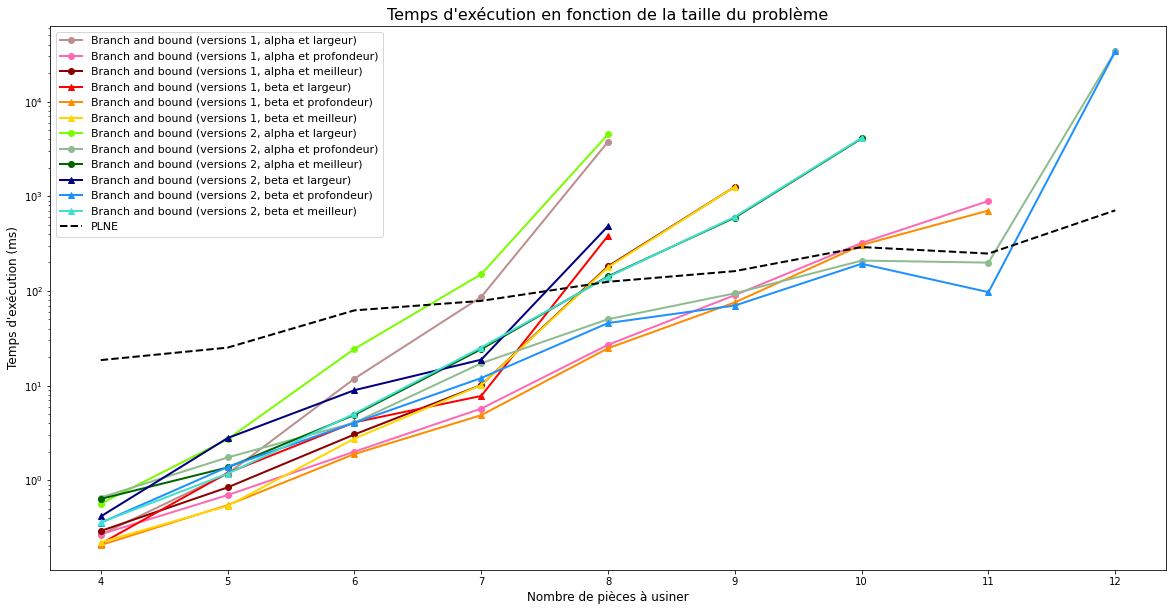

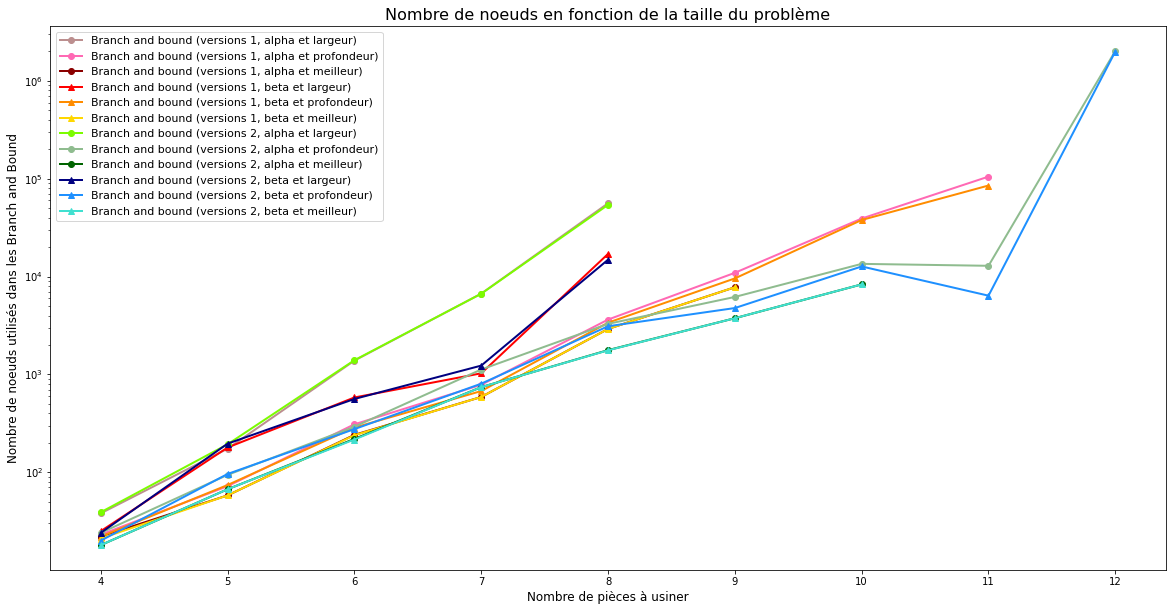

In [ ]:
fig = plt.figure(figsize=(20,10))
plt.plot(NB_pieces_4_a_8 , sec_to_millisec(Tps_BandB_1al), "o-", label = 'Branch and bound (versions 1, alpha et largeur)', color='rosybrown', linewidth=2)
plt.plot(NB_pieces_4_a_11, sec_to_millisec(Tps_BandB_1ap), "o-", label = 'Branch and bound (versions 1, alpha et profondeur)', color='hotpink', linewidth=2)
plt.plot(NB_pieces_4_a_9 , sec_to_millisec(Tps_BandB_1am), "o-", label = 'Branch and bound (versions 1, alpha et meilleur)', color='darkred', linewidth=2)
plt.plot(NB_pieces_4_a_8 , sec_to_millisec(Tps_BandB_1bl), "^-", label = 'Branch and bound (versions 1, beta et largeur)', color='red', linewidth=2)
plt.plot(NB_pieces_4_a_11, sec_to_millisec(Tps_BandB_1bp), "^-", label = 'Branch and bound (versions 1, beta et profondeur)', color='darkorange', linewidth=2)
plt.plot(NB_pieces_4_a_9 , sec_to_millisec(Tps_BandB_1bm), "^-", label = 'Branch and bound (versions 1, beta et meilleur)', color='gold', linewidth=2)
plt.plot(NB_pieces_4_a_8 , sec_to_millisec(Tps_BandB_2al), "o-", label = 'Branch and bound (versions 2, alpha et largeur)', color='lawngreen', linewidth=2)
plt.plot(NB_pieces_4_a_12, sec_to_millisec(Tps_BandB_2ap), "o-", label = 'Branch and bound (versions 2, alpha et profondeur)', color='darkseagreen', linewidth=2)
plt.plot(NB_pieces_4_a_10, sec_to_millisec(Tps_BandB_2am), "o-", label = 'Branch and bound (versions 2, alpha et meilleur)', color='darkgreen', linewidth=2)
plt.plot(NB_pieces_4_a_8 , sec_to_millisec(Tps_BandB_2bl), "^-", label = 'Branch and bound (versions 2, beta et largeur)', color='navy', linewidth=2)
plt.plot(NB_pieces_4_a_12, sec_to_millisec(Tps_BandB_2bp), "^-", label = 'Branch and bound (versions 2, beta et profondeur)', color='dodgerblue', linewidth=2)
plt.plot(NB_pieces_4_a_10, sec_to_millisec(Tps_BandB_2bm), "^-", label = 'Branch and bound (versions 2, beta et meilleur)', color='turquoise', linewidth=2)
plt.plot(NB_pieces_4_a_12, sec_to_millisec(Tps_PLNE), "k--", label = 'PLNE', linewidth=2)
plt.yscale("log")
plt.xlabel("Nombre de pièces à usiner", size=12)
plt.ylabel("Temps d'exécution (ms)", size=12)
plt.title("Temps d'exécution en fonction de la taille du problème", size=16)
plt.legend(prop={'size':11})
plt.show()

print("")

fig = plt.figure(figsize=(20,10))
plt.plot(NB_pieces_4_a_8 , NB_noeuds_1al, "o-", label = 'Branch and bound (versions 1, alpha et largeur)', color='rosybrown', linewidth=2)
plt.plot(NB_pieces_4_a_11, NB_noeuds_1ap, "o-", label = 'Branch and bound (versions 1, alpha et profondeur)', color='hotpink', linewidth=2)
plt.plot(NB_pieces_4_a_9 , NB_noeuds_1am, "o-", label = 'Branch and bound (versions 1, alpha et meilleur)', color='darkred', linewidth=2)
plt.plot(NB_pieces_4_a_8 , NB_noeuds_1bl, "^-", label = 'Branch and bound (versions 1, beta et largeur)', color='red', linewidth=2)
plt.plot(NB_pieces_4_a_11, NB_noeuds_1bp, "^-", label = 'Branch and bound (versions 1, beta et profondeur)', color='darkorange', linewidth=2)
plt.plot(NB_pieces_4_a_9 , NB_noeuds_1bm, "^-", label = 'Branch and bound (versions 1, beta et meilleur)', color='gold', linewidth=2)
plt.plot(NB_pieces_4_a_8 , NB_noeuds_2al, "o-", label = 'Branch and bound (versions 2, alpha et largeur)', color='lawngreen', linewidth=2)
plt.plot(NB_pieces_4_a_12, NB_noeuds_2ap, "o-", label = 'Branch and bound (versions 2, alpha et profondeur)', color='darkseagreen', linewidth=2)
plt.plot(NB_pieces_4_a_10, NB_noeuds_2am, "o-", label = 'Branch and bound (versions 2, alpha et meilleur)', color='darkgreen', linewidth=2)
plt.plot(NB_pieces_4_a_8 , NB_noeuds_2bl, "^-", label = 'Branch and bound (versions 2, beta et largeur)', color='navy', linewidth=2)
plt.plot(NB_pieces_4_a_12, NB_noeuds_2bp, "^-", label = 'Branch and bound (versions 2, beta et profondeur)', color='dodgerblue', linewidth=2)
plt.plot(NB_pieces_4_a_10, NB_noeuds_2bm, "^-", label = 'Branch and bound (versions 2, beta et meilleur)', color='turquoise', linewidth=2)
plt.yscale("log")
plt.xlabel("Nombre de pièces à usiner", size=12)
plt.ylabel("Nombre de noeuds utilisés dans les Branch and Bound", size=12)
plt.title("Nombre de noeuds en fonction de la taille du problème", size=16)
plt.legend(prop={'size':11})
plt.show()


À partir de deux différentes règles de branchement avec leurs versions de calcul de borne duale correspondantes (versions 1 et 2), deux versions de calcul de borne primale $\alpha$ et $\beta$ et trois méthodes d'exploration, on a donc fait toutes les combinaisions possibles pour la fonction `branch_and_bound()` et on a représenté graphiquement leurs complexités en terme de temps d'exécution et de nombres de nœuds de branchement (pour faciliter la lecture des courbes, noter que les versions 1 sont en couleurs chaudes, les versions 2 en couleurs froides, les versions $\alpha$ ont des ronds et les versions $\beta$ ont des triangles.)  
À ces algorithmes, on a également comparé le temps d'exécution de la fonction `PLNE()`.    

Afin de pouvoir correctement comparer les complexités, on a fixé une graine de génération aléatoire pour que chaque algorithme soit utilisé sur les mêmes problèmes d'ordonnancement.

Les Branch and Bound avec la méthode d'exploration en largeur ont les complexités qui augmentent les plus rapidement, de sorte que l'on a choisi ici de ne pas les utiliser pour plus de 8 pièces. Au contraire, la méthode d'exploration en profondeur donne les meilleurs temps de calcul par rapport aux deux autres méthodes.   

La méthode d'exploration "meilleur d'abord" donne des temps d'exécution intérmédiaires aux deux autres méthodes. Par contre, elle traite en général le moins de noeuds de branchement, en particulier avec la version 2 de règle de branchement.

Dans presque tous les cas, la version 2 donne de meilleurs temps d'exécution qu'avec la version 1 de règle de branchement et calcul de borne duale.

En ce qui concerne le choix de calcul de borne primale, on ne peut noter de différence importante entre les deux versions $\alpha$ et $\beta$ seulement lorsque l'on choisi une exploration en largeur. La version $\alpha$ est dans ce cas plus longue en temps d'exécution et plus grand en nombre de nœuds que la version $\beta$. Dans les autres cas, le choix de calcul de borne primale semble avoir peu d'influence sur les complexités ici.

Enfin, la PLNE est plus longue que les Branch and Bound sur des petites tailles de problèmes, mais semble devenir meilleure que tous ces algorithmes lorsque le problème devient plus grand. En outre, la pente de la courbe de temps de la PLNE est plus petite que la pente des courbes de Branch and Bound. Sa complexité en fonction de la taille du problème est donc très certainement meilleure.

$\phantom{saut de ligne}$

En conclusion, pour ces problèmes d'ordonnancement, choisir la version 2 pour la règle de branchement et le calcul de borne duale (ordonnancement des pièces par la fin) avec une méthode d'exploration en profondeur, permet d'obtenir ici l'algorithme de Branch and Bound le plus rapide en temps et le moins coûteux en nombre de nœuds de branchement. On devrait aussi plutôt choisir la version $\alpha$ de calcul de borne primale (pourtant moins élaborée que la version $\beta$), mais ceci ne semble pas grandement influer sur les complexités dans ces conditions.

Cette étude de complexité nous montre aussi surtout que le choix des composantes du Branch and Bound a une influence très importante sur sa performance de résolution de problème. Mais bien que ce choix soit crucial, il ne semble pas aisé de déterminer à l'avance quels calculs de bornes, règle de branchement et méthode d'exploration donneront les meilleurs résultats.
